In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import collections
import gymnasium as gym
import random

In [8]:
## Predefined functions from rl_utils
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

In [9]:
## Predefined functions from rl_utils
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

In [10]:
class P_net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(P_net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=0) # "dim=1" to be detailed, may be related to action space

In [11]:
## REINFORCE algorithm (Primitive MC + Policy Gradient)
class REINFORCE:
    ''' REINFORCE algorithm implementation '''
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # policy network
        self.P_net = P_net(state_dim, hidden_dim, action_dim).to(device)
        # optimizer and hyperparameters
        self.optimizer = torch.optim.Adam(self.P_net.parameters(), lr=lr)
        self.gamma = gamma
        self.device = device
        
    def action_selection(self, state): # random sampling according to the policy probabilities distribution
        state_tensor = torch.tensor(state, dtype=torch.float).to(self.device)
        prob_policy = self.P_net(state_tensor)
        dist = torch.distributions.Categorical(prob_policy)
        action = dist.sample().item()
        return action
    
    def REINFORCE_main(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        
        G = 0
        self.optimizer.zero_grad()
        # Estimate G
        # generate an eposiode and calculate the return G
        for i in reversed(range(len(rewards))):
            reward = rewards[i]
            state = states[i]
            action = actions[i]
            prob_mid = self.P_net(state)
            ln_prob = torch.log(prob_mid[action])
            G = reward + self.gamma * G
            loss = -ln_prob * G
            loss.backward() # theta = theta + alpha*gamma^?*G*grad_ln(pi(a|s, theta))   
        # optimizer
        self.optimizer.step()
        
        

In [12]:
## REINFORCE main program
lr = 2e-3  # learning rate
hidden_dim = 100
gamma = 0.98 # discount factor
# epsilon = 0.05 # exploration rate
num_episodes = 500 # number of episodes to train
# buffer_size = 10000 # replay buffer size
# minimal_size = 500 # minimal size of replay buffer to start training
# batch_size = 100 # batch size for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

# C.I.A.L.L.O. random seed
env.action_space.seed(0)
random.seed(7)
np.random.seed(2)
torch.manual_seed(1)

state_dim = env.observation_space.shape[0] # default dim = 4, position, velocity, angle, angular velocity
action_dim = env.action_space.n # default dim = 2 (Bang-Bang control), can be changed to 3 or more
agent = REINFORCE(state_dim, hidden_dim, action_dim, lr, gamma, device)

return_list = []
for i in range(10):
    for i_ep in range(int(num_episodes/10)):
        # reset the environment and transition dictionary
        episode_return = 0
        state, _ = env.reset()
        done = False
        transition_dict = {'states': [], 'actions': [], 'rewards': [], 'next_states': [], 'dones': []}
        # simulate an entire episode
        while not done:
            # step forward
            action = agent.action_selection(state)
            next_state, reward, done, _, _ = env.step(action)
            # store the transition in the transition dictionary
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['rewards'].append(reward)
            transition_dict['next_states'].append(next_state)
            transition_dict['dones'].append(done)
            state = next_state # update state
            episode_return += reward # record the return
        # After the episode ends, we use the G obtained from the episode to update the policy network
        return_list.append(episode_return)
        agent.REINFORCE_main(transition_dict)
        # print the return every 10 episodes
        if (i_ep + 1) % 10 == 0:
            print(f'Episode {i * int(num_episodes/10) + i_ep + 1}, Return: {episode_return}')

/tmp/ipykernel_1596198/1367027056.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)


Episode 10, Return: -345.9896729195183
Episode 20, Return: -245.30108444652916
Episode 30, Return: -353.38903215946993
Episode 40, Return: -365.9534931131004
Episode 50, Return: -26.6105867293884
Episode 60, Return: -74.35135412202823
Episode 70, Return: -167.45973344621183
Episode 80, Return: -432.11908298720004
Episode 90, Return: -58.006951269919945
Episode 100, Return: -2.782185289934489
Episode 110, Return: -347.3393263768053
Episode 120, Return: -130.78875722511418
Episode 130, Return: -141.7532620764574
Episode 140, Return: -135.82338281985173
Episode 150, Return: -124.3440536987252
Episode 160, Return: -137.3817643614996
Episode 170, Return: -123.59814947571147
Episode 180, Return: -123.0268308846326
Episode 190, Return: -183.06453507482294
Episode 200, Return: -99.3066330691607
Episode 210, Return: -151.83744841744402
Episode 220, Return: -62.160750172856346
Episode 230, Return: -74.20649486233054
Episode 240, Return: -342.31831373251134
Episode 250, Return: -182.7487473740449

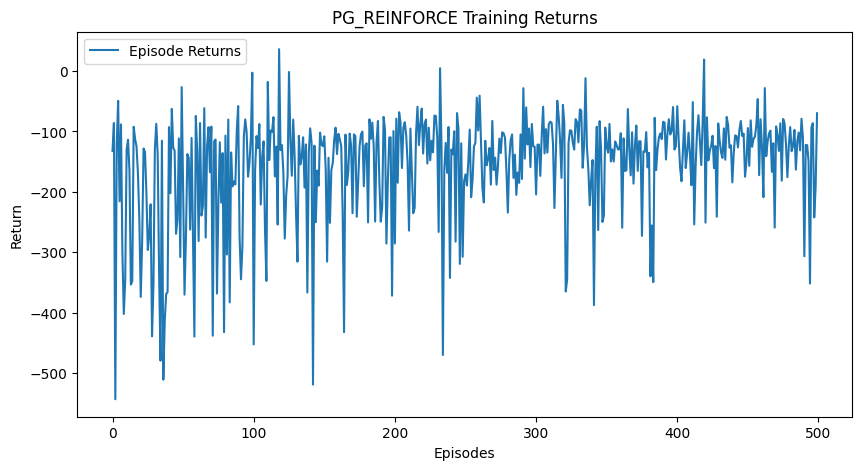

In [13]:
## Plotting the results
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(10, 5))
plt.plot(episodes_list, return_list, label='Episode Returns')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('PG_REINFORCE Training Returns')
plt.legend()

# move average return list to be added